# todo: add the params to some model names

In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from models.hawkes_model import HawkesModelGeneral, IndHawkesModel
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup

from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup


from utils.plots import DistributionPlotter
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, CellPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report
import pickle
from utils.utils import pshape, pmax, pmin, pmean, get_data_sub_paths
import os

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_models,\
                                get_models_metrics, get_models_results, get_metrics_table
from models.baseline_models import ExponentialMovingAverage, UniformMovingAverage, \
                                    TriangularMovingAverage, HistoricAverage


In [3]:
data_sub_paths = get_data_sub_paths()
data_sub_paths

['T3H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X85M-Y110M_2013-01-01_2015-01-01',
 'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
 'T12H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X255M-Y220M_2013-01-01_2015-01-01',
 'T6H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X425M-Y440M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2015-01-01',
 'T1H-X850M-Y880M_2013-01-01_2015-01-01']

In [4]:
data_sub_paths = ['T24H-X850M-Y880M_2013-01-01_2015-01-01']

In [5]:
# test if the grid and flat datagroups have the same shapers.
for data_sub_path in data_sub_paths:
    conf = BaseConf()
    conf.data_path = f"./data/processed/{data_sub_path}/"    
#     conf.data_path = #"./data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/"
    flat_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    flat_loaders = FlatDataLoaders(data_group=flat_group, conf=conf)

    grid_group = GridDataGroup(data_path=conf.data_path, conf=conf)
    grid_loaders = GridDataLoaders(data_group=grid_group, conf=conf)

    print(f"{grid_group.shaper.l == flat_group.shaper.l} -> {conf.data_path}")

True -> ./data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/


In [6]:
# run base line models for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
    
    conf.data_path = f"./data/processed/{data_sub_path}/"
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "=====================================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # LOAD DATA
    conf.shaper_threshold = 0
    conf.shaper_top_k = -1
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
        
    # ------------HAWKES INDEPENDENT MODEL
    conf.model_name = f"Ind-Hawkes Model"  # tod add the actual parameters as well
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("=====================================BEGIN=====================================")
    test_set_size = data_group.testing_set.target_shape[0]

    trn_crimes = data_group.training_set.crimes[:,0]
    trn_y_true = data_group.training_set.targets

    tst_crimes = data_group.testing_set.crimes[:,0]
    tst_y_true = data_group.testing_set.targets
    tst_t_range = data_group.testing_set.t_range

    # time step in this context is used for 
    freqstr = data_group.t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))

    kernel_size = time_step*30

    N,L = np.shape(trn_crimes)

    model = IndHawkesModel(kernel_size=kernel_size)
    trn_probas_pred = model.fit_transform(trn_crimes)

    thresh = best_threshold(y_true=trn_y_true,
                            probas_pred=trn_probas_pred)

    tst_probas_pred = model.transform(tst_crimes)
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)

    tst_y_true = tst_y_true[-test_set_size:]
    tst_y_pred = tst_y_pred[-test_set_size:]
    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
    tst_probas_pred = tst_probas_pred[-test_set_size:]
    tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)
    tst_t_range = tst_t_range[-test_set_size:]

    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  
    
    # ------------HAWKES INDEPENDENT MODEL    

2019-11-08T11:03:07 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X850M-Y880M_2013-01-01_2015-01-01
2019-11-08T11:03:07 | root | INFO | 	t_range shape (731,)
2019-11-08T11:03:07 | root | INFO | =====================================BEGIN=====================================
2019-11-08T11:03:20 | root | INFO | f1_score: 0.7322132807503731 at index 110260, new threshold 0.26957005474048573
2019-11-08T11:03:20 | root | INFO | 
        MODEL METRICS
            Model Name: Ind-Hawkes Model
                ROC AUC:            0.7855941517153655                
                Average Precision:  0.7449931939201502
                Precision:          0.5918394382989998
                Recall:             0.8593825141867847
                Accuracy:           0.6708970042303376
                MCC:                0.3933660282385177          
        
2019-11-08T11:03:20 | root | INFO | 
        MODEL RESULT
            Model Name: Ind-Hawkes Model
                ROC AUC:            

In [7]:
# run base line models for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
    
    conf.data_path = f"./data/processed/{data_sub_path}/"
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "=====================================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # LOAD DATA
    conf.shaper_threshold = 0
    conf.shaper_top_k = -1
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
        
    # ------------HAWKES GENERAL MODEL
    conf.model_name = f"Hawkes General Model"  # tod add the actual parameters as well
    conf.model_path = conf.data_path + f"models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("=====================================BEGIN=====================================")
    test_set_size = data_group.testing_set.target_shape[0]

    trn_crimes = data_group.training_set.crimes[:,0]
    trn_y_true = data_group.training_set.targets

    tst_crimes = data_group.testing_set.crimes[:,0]
    tst_y_true = data_group.testing_set.targets
    tst_t_range = data_group.testing_set.t_range

    # time step in this context is used for 
    freqstr = data_group.t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))

    kernel_size = time_step*30

    N,L = np.shape(trn_crimes)

    model = HawkesModelGeneral(kernel_size=kernel_size)
    trn_probas_pred = model.fit_transform(trn_crimes)

    thresh = best_threshold(y_true=trn_y_true,
                            probas_pred=trn_probas_pred)

    tst_probas_pred = model.transform(tst_crimes)
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)

    tst_y_true = tst_y_true[-test_set_size:]
    tst_y_pred = tst_y_pred[-test_set_size:]
    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
    tst_probas_pred = tst_probas_pred[-test_set_size:]
    tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)
    tst_t_range = tst_t_range[-test_set_size:]

    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  
    
    # ------------HAWKES GENERAL MODEL    

2019-11-08T11:03:21 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X850M-Y880M_2013-01-01_2015-01-01
2019-11-08T11:03:21 | root | INFO | 	t_range shape (731,)
2019-11-08T11:03:21 | root | INFO | =====================================BEGIN=====================================
2019-11-08T11:03:21 | root | INFO | f1_score: 0.7118452539218293 at index 84882, new threshold 0.11888942398593859
2019-11-08T11:03:22 | root | INFO | 
        MODEL METRICS
            Model Name: Hawkes General Model
                ROC AUC:            0.764797289097411                
                Average Precision:  0.7253196593196006
                Precision:          0.5834710743801653
                Recall:             0.8374851720047449
                Accuracy:           0.6587383809606032
                MCC:                0.3643159229081676          
        
2019-11-08T11:03:22 | root | INFO | 
        MODEL RESULT
            Model Name: Hawkes General Model
                ROC AUC:      

2019-11-08T11:03:23 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X850M-Y880M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-08T11:03:23 | root | INFO | =====================================BEGIN=====================================
2019-11-08T11:03:23 | root | INFO | 	t_range shape (731,)
2019-11-08T11:03:23 | root | INFO | class distribution: {0.0: 0.5256703363699249, 1.0: 0.47432966363007517}


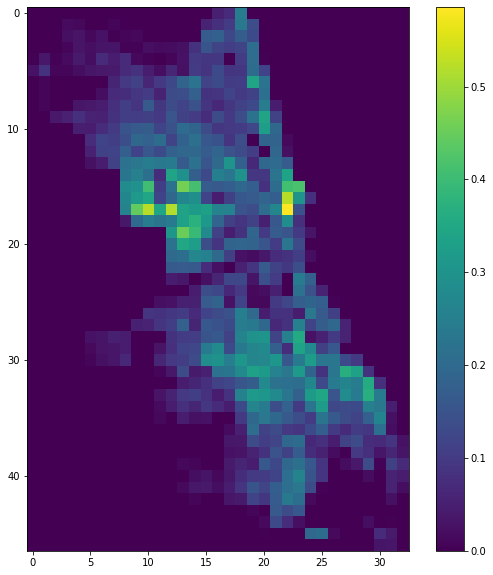

2019-11-08T11:03:23 | root | INFO | =====================================BEGIN=====================================
2019-11-08T11:03:23 | root | INFO | using time step: 7
2019-11-08T11:03:24 | root | INFO | f1_score: 0.7226309706466281 at index 11248, new threshold 0.08097721274085151
2019-11-08T11:03:24 | root | INFO | ======== ./data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-08T11:03:24 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.7858663871043998                
                Average Precision:  0.7466606307779609
                Precision:          0.5876148569949528
                Recall:             0.8734250264499375
                Accuracy:           0.6680911680911681
                MCC:                0.3950736664269501          
        
2019-11-08T11:03:24 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
              

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-08T11:03:27 | root | INFO | =====================================END=====================================



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [8]:
# run base line models for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
  
    conf.data_path = f"./data/processed/{data_sub_path}/"
    
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "===t==================================================")

    log.info("=====================================BEGIN=====================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # DATA LOADER SETUP
    np.random.seed(conf.seed)

    conf.shaper_threshold = 0
    conf.shaper_top_k = -1

    # CRIME DATA
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
    
    # LOG CLASS DISTRIBUTION
    vals, counts = np.unique(data_group.targets,return_counts=True)
    counts = counts/np.sum(counts)
    dist = dict(zip(vals,counts))
    log.info(f"class distribution: {dist}")

    test_set_size = data_group.testing_set.target_shape[0]
    crimes = data_group.shaper.unsqueeze(data_group.crimes)
    im(crimes.mean(0)[0])
    crimes = data_group.crimes
    t_range = data_group.t_range

    # -----------HISTORIC AVERAGE
    # Create model folder and setup logging for model
    conf.model_name = "Historic Average"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")

    # time step in this context is used for 
    freqstr = t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))
    if time_step == 1:
        time_step = 7  # historic average to a week when time scale is daily

    log.info(f"using time step: {time_step}")

    test_set_size = data_group.testing_set.target_shape[0]

    ha = HistoricAverage(step=time_step)
    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_crimes_ha = ha(all_crimes)
    all_t_range = data_group.t_range

    tst_crimes_ha = all_crimes_ha[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_crimes_ha[time_step+1:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[time_step+1:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_probas_pred = tst_crimes_ha
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # -----------HISTORIC AVERAGE

    # -----------GLOBAL AVERAGE
    # Create model folder and setup logging for model
    conf.model_name = "Global Average"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")


    test_set_size = data_group.testing_set.target_shape[0]

    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets

    trn_crimes = all_crimes[:-test_set_size]
    trn_targets = all_targets[:-test_set_size]

    tst_crimes = all_crimes[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_mean = np.mean(trn_crimes,axis=0,keepdims=True)  # keep dims used to make scalar product easy
    trn_ones = np.ones_like(trn_crimes,dtype=np.float)
    trn_probas_pred = trn_mean*trn_ones

    thresh = best_threshold(y_true=trn_targets,
                            probas_pred=trn_probas_pred) # should only come from the train predictions

    # only use the training sets - mean
    tst_ones = np.ones_like(tst_crimes,dtype=np.float)
    tst_probas_pred = trn_mean*tst_ones

    tst_y_true = tst_targets
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # -----------GLOBAL AVERAGE

#     # ------------Uniform Moving Average
#     # Create model folder and setup logging for model
#     conf.model_name = "Uni. Mov. Avg."  # needs to be created
#     conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
#     log.info("=====================================BEGIN=====================================")

#     # time step in this context is used for 
#     freqstr = t_range.freqstr
#     if freqstr == "H":
#         freqstr = "1H"
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))
#     time_step = 30*time_step

#     log.info(f"using time step: {time_step}")

#     test_set_size = data_group.testing_set.target_shape[0]

#     window_len=time_step

#     ma = UniformMovingAverage(window_len=window_len)

#     all_crimes = data_group.crimes[:,0]
#     all_targets = data_group.targets
#     all_probas_pred = ma(all_crimes)
#     all_t_range = data_group.t_range

#     tst_probas_pred = all_probas_pred[-test_set_size:]
#     tst_targets = all_targets[-test_set_size:]
#     tst_t_range = all_t_range[-test_set_size:]

#     trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
#     trn_y_true = all_targets[time_step+1:-test_set_size]

#     thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

#     tst_y_true = tst_targets
#     tst_probas_pred = tst_probas_pred
#     tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

#     tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
#     tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

#     log.info(f"======== {conf.model_path}  ========")
#     save_metrics(y_true=tst_y_true,
#                  y_pred=tst_y_pred,
#                  probas_pred=tst_probas_pred,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,                
#                  conf=conf)  

#     log.info("=====================================END=====================================\n")
#     # ------------Uniform Moving Average
    
#     # ------------Exponential Moving Average
#     # Create model folder and setup logging for model
#     conf.model_name = "Exp. Mov. Avg."  # needs to be created
#     conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
#     log.info("=====================================BEGIN=====================================")

#     # time step in this context is used for 
#     freqstr = t_range.freqstr
#     if freqstr == "H":
#         freqstr = "1H"
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))
#     time_step = 30*time_step

#     log.info(f"using time step: {time_step}")

#     test_set_size = data_group.testing_set.target_shape[0]

#     alpha=1e-2
#     window_len=time_step

#     ma = ExponentialMovingAverage(alpha=alpha,window_len=window_len)

#     all_crimes = data_group.crimes[:,0]
#     all_targets = data_group.targets
#     all_probas_pred = ma(all_crimes)
#     all_t_range = data_group.t_range

#     tst_probas_pred = all_probas_pred[-test_set_size:]
#     tst_targets = all_targets[-test_set_size:]
#     tst_t_range = all_t_range[-test_set_size:]

#     trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
#     trn_y_true = all_targets[time_step+1:-test_set_size]

#     thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

#     tst_y_true = tst_targets
#     tst_probas_pred = tst_probas_pred
#     tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

#     tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
#     tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

#     log.info(f"======== {conf.model_path}  ========")
#     save_metrics(y_true=tst_y_true,
#                  y_pred=tst_y_pred,
#                  probas_pred=tst_probas_pred,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,                
#                  conf=conf)  

#     log.info("=====================================END=====================================\n")
#     # ------------Exponential Moving Average
    
#     # ------------Triangular Moving Average
#     # Create model folder and setup logging for model
#     conf.model_name = "Tri. Mov. Avg."  # needs to be created
#     conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
#     os.makedirs(conf.model_path, exist_ok=True)
#     setup_logging(save_dir=conf.model_path,
#                   log_config='./logger/standard_logger_config.json',
#                   default_level=log.INFO)
#     log.info("=====================================BEGIN=====================================")

#     # time step in this context is used for 
#     freqstr = t_range.freqstr
#     if freqstr == "H":
#         freqstr = "1H"
#     time_step = int(24 / int(freqstr[:freqstr.find("H")]))
#     time_step = 30*time_step

#     log.info(f"using time step: {time_step}")

#     test_set_size = data_group.testing_set.target_shape[0]

#     window_len=time_step

#     ma = TriangularMovingAverage(window_len=window_len)

#     all_crimes = data_group.crimes[:,0]
#     all_targets = data_group.targets
#     all_probas_pred = ma(all_crimes)
#     all_t_range = data_group.t_range

#     tst_probas_pred = all_probas_pred[-test_set_size:]
#     tst_targets = all_targets[-test_set_size:]
#     tst_t_range = all_t_range[-test_set_size:]

#     trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
#     trn_y_true = all_targets[time_step+1:-test_set_size]

#     thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

#     tst_y_true = tst_targets
#     tst_probas_pred = tst_probas_pred
#     tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

#     tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
#     tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

#     log.info(f"======== {conf.model_path}  ========")
#     save_metrics(y_true=tst_y_true,
#                  y_pred=tst_y_pred,
#                  probas_pred=tst_probas_pred,
#                  t_range=tst_t_range,
#                  shaper=data_group.shaper,                
#                  conf=conf)  

#     log.info("=====================================END=====================================\n")
#     # ------------Triangular Moving Average
    
    
    # ------------PREVIOUS TIME STEP
    # Create model folder and setup logging for model
    conf.model_name = "Previous Time Step"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")


    test_set_size = data_group.testing_set.target_shape[0]

    all_probas_pred = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_t_range = data_group.t_range

    tst_probas_pred = all_probas_pred[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_probas_pred[:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)
    
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # ------------PREVIOUS TIME STEP

In [9]:
data_sub_paths

['T24H-X850M-Y880M_2013-01-01_2015-01-01']

2019-11-08T11:03:27 | root | INFO | T24H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-08T11:03:27 | root | INFO | 
                       ROC AUC  Avg. Precision  Precision    Recall  F1 Score  \
Model Name                                                                      
Historic Average      0.785866        0.746661   0.587615  0.873425  0.702565   
Global Average        0.786672        0.745822   0.591271  0.865153  0.702460   
Ind-Hawkes Model      0.785594        0.744993   0.591839  0.859383  0.700949   
Kang FNN              0.776400        0.731595   0.586425  0.861466  0.697822   
Hawkes General Model  0.764797        0.725320   0.583471  0.837485  0.687774   
ST-RESNET-Extra       0.772593        0.737414   0.549236  0.897502  0.681451   
ST-RESNET             0.762557        0.734436   0.476522  0.964349  0.637855   
Previous Time Step    0.653737        0.585656   0.448804  1.000000  0.619551   

                      Accuracy  Matthews Corrcoef  
Model Name              

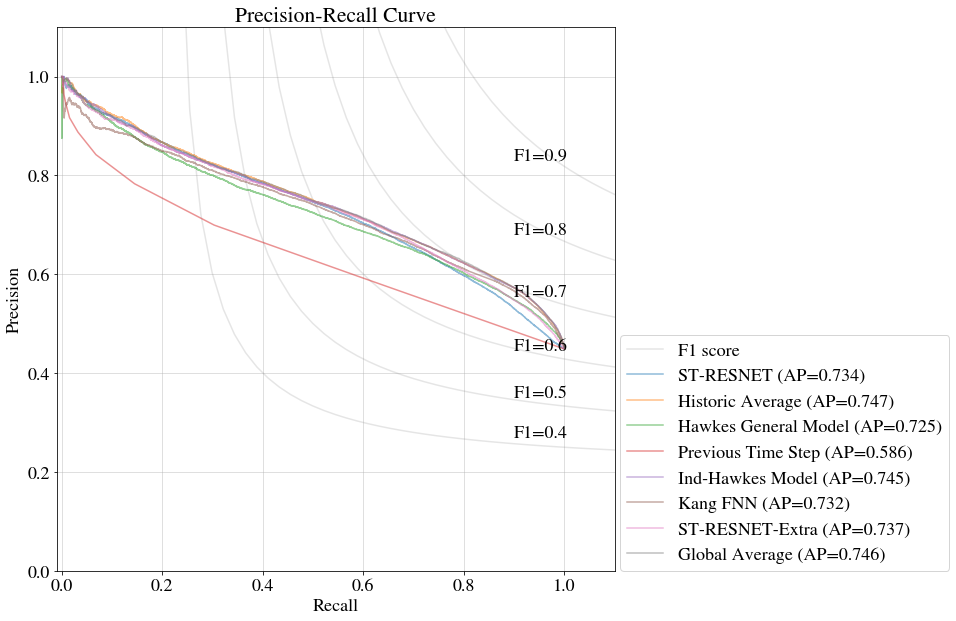

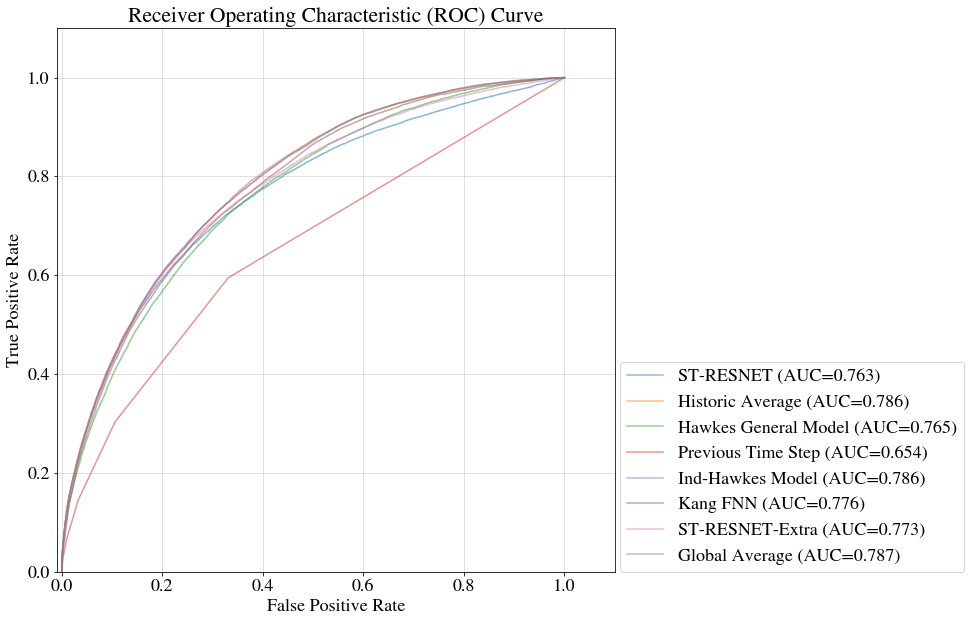

In [10]:
# data_path = conf.model_path[:conf.model_path.find("models")]
for data_sub_path in data_sub_paths:
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"

    compare_models(data_path)

2019-11-08T11:03:28 | root | INFO | 
                       ROC AUC  Avg. Precision  Precision    Recall  F1 Score  \
Model Name                                                                      
Historic Average      0.785866        0.746661   0.587615  0.873425  0.702565   
Global Average        0.786672        0.745822   0.591271  0.865153  0.702460   
Ind-Hawkes Model      0.785594        0.744993   0.591839  0.859383  0.700949   
Kang FNN              0.776400        0.731595   0.586425  0.861466  0.697822   
Hawkes General Model  0.764797        0.725320   0.583471  0.837485  0.687774   
ST-RESNET-Extra       0.772593        0.737414   0.549236  0.897502  0.681451   
ST-RESNET             0.762557        0.734436   0.476522  0.964349  0.637855   
Previous Time Step    0.653737        0.585656   0.448804  1.000000  0.619551   

                      Accuracy  Matthews Corrcoef  
Model Name                                         
Historic Average      0.668091           0.39507

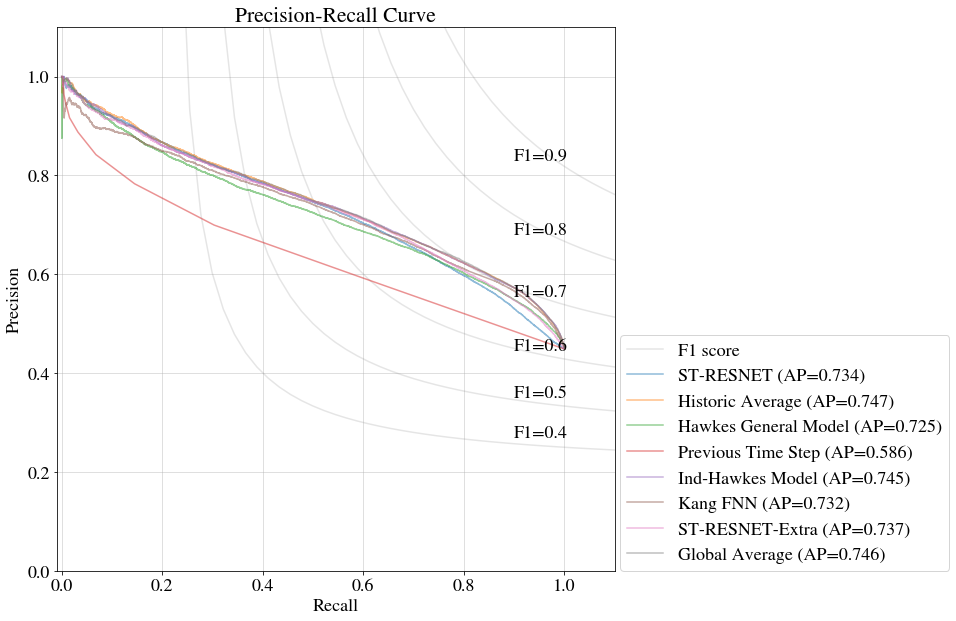

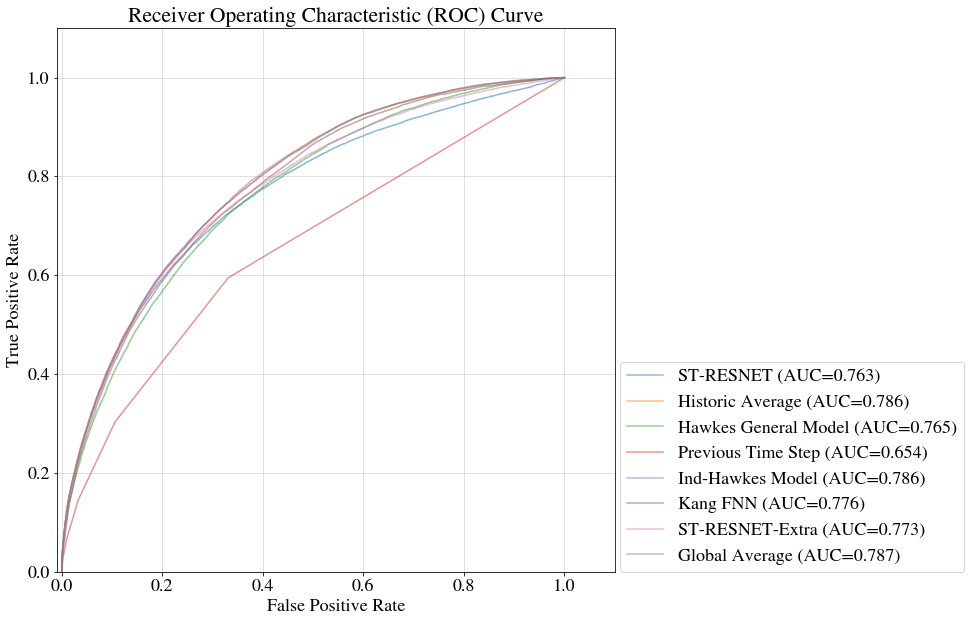

,ROC AUC,Avg. Precision,Precision,Recall,F1 Score,Accuracy,Matthews Corrcoef
Model Name,,,,,,,
Historic Average,0.785866,0.746661,0.587615,0.873425,0.702565,0.668091,0.395074
Global Average,0.786672,0.745822,0.591271,0.865153,0.702460,0.671070,0.396162
Ind-Hawkes Model,0.785594,0.744993,0.591839,0.859383,0.700949,0.670897,0.393366
Kang FNN,0.776400,0.731595,0.586425,0.861466,0.697822,0.665156,0.384909
Hawkes General Model,0.764797,0.725320,0.583471,0.837485,0.687774,0.658738,0.364316
ST-RESNET-Extra,0.772593,0.737414,0.549236,0.897502,0.681451,0.623414,0.334900
ST-RESNET,0.762557,0.734436,0.476522,0.964349,0.637855,0.508547,0.175342
Previous Time Step,0.653737,0.585656,0.448804,1.000000,0.619551,0.448804,0.000000


In [11]:
compare_models(data_path)

In [23]:
for data_sub_path in data_sub_paths:
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"

    models_metrics = get_models_metrics(data_path)
    metrics_table = get_metrics_table(models_metrics)
    print(metrics_table)
    print("\n===================================================================================================\n")

2019-11-07T22:54:12 | root | INFO | T3H-X850M-Y880M_2013-01-01_2015-01-01

                       ROC AUC  Avg. Precision  Precision    Recall  F1 Score  \
Model Name                                                                      
Historic Average      0.753655        0.246152   0.227663  0.452580  0.318873   
Ind-Hawkes Model      0.732156        0.229147   0.213494  0.428389  0.298582   
Global Average        0.731416        0.210335   0.193046  0.487095  0.293802   
Hawkes General Model  0.699960        0.190031   0.190952  0.387133  0.254927   
Previous Time Step    0.545570        0.105401   0.170390  0.170307  0.130214   

                      Accuracy  Matthews Corrcoef  
Model Name                                         
Historic Average      0.816567           0.226921  
Ind-Hawkes Model      0.810666           0.205045  
Global Average        0.775505           0.197994  
Hawkes General Model  0.801565           0.169251  
Previous Time Step    0.853899           0.09

                       ROC AUC  Avg. Precision  Precision    Recall  F1 Score  \
Model Name                                                                      
Historic Average      0.747532        0.101228   0.115414  0.257538  0.145331   
Ind-Hawkes Model      0.710276        0.090826   0.109864  0.215917  0.127865   
Global Average        0.727132        0.082812   0.095176  0.275203  0.127314   
Hawkes General Model  0.681533        0.069940   0.086876  0.203789  0.104140   
Previous Time Step    0.522583        0.035261   0.075180  0.075180  0.048006   

                      Accuracy  Matthews Corrcoef  
Model Name                                         
Historic Average      0.914354           0.132059  
Ind-Hawkes Model      0.920120           0.115217  
Global Average        0.894656           0.115359  
Hawkes General Model  0.907360           0.089510  
Previous Time Step    0.941682           0.045072  




# Try training a model per cell

--------

In [14]:
start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = "T24H-X850M-Y880M"  #"T1H-X1700M-Y1760M"  "T3H-X850M-Y880M" # needs to exist
data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"

model_name = "test-logging-change"  # needs to be created
model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")


if not os.path.exists(data_path):
    raise Exception(f"Directory ({data_path}) needs to exist.")

timer = Timer()
# manually set the config
# manually set the config
conf_dict = {
    "seed": 3,
    "use_cuda": False,
    
    "use_crime_types": False,
    
    # data group/data set related
    "val_ratio": 0.1,  # ratio of the total dataset
    "tst_ratio": 0.3,# ratio of the total dataset
    "seq_len": 1,
    "flatten_grid": True,  # if the shaper should be used to squeeze the data
    
    # shaper related 
    "shaper_top_k": -1,  # if less then 0, top_k will not be applied
    "shaper_threshold": 0,

    
    # data loader related
    "sub_sample_train_set": 1,
    "sub_sample_validation_set": 1,
    "sub_sample_validation_set": 0,
    
    # training parameters
    "resume": False,
    "early_stopping": False,
    "tolerance": 1e-8,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 1,
    "batch_size": 64,
    "dropout": 0.2,
    "shuffle": False,
    "num_workers": 6,
    
    # attached global variables - bad practice -find alternative
    "device": None,  # pytorch device object [CPU|GPU]
    "timer": Timer(),
    "model_name": model_name,
    "model_path": model_path,
    "checkpoint": "best",
    
    "use_seq_loss": True,
}
conf = BaseConf(conf_dict=conf_dict)

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed( conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
info["device"] = device.type
conf.device = device

2019-11-02T20:01:55 | root | INFO | =====================================BEGIN=====================================


2019-11-02T20:02:03 | root | INFO | 	t_range shape (731,)
threshold: -1 - targets.shape: (729, 1, 770)
class distribution: {0.0: 0.564881620437176, 1.0: 0.435118379562824}


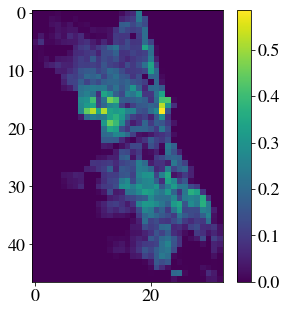

In [15]:
# visualize the cells that we are dropping
conf.shaper_threshold = 0
conf.shaper_top_k = -1

for i in [-1]:
    conf.shaper_top_k = i
    data_group = FlatDataGroup(data_path=data_path, conf=conf)
    print(f"threshold: {i} - targets.shape: {data_group.targets.shape}")
    vals, counts = np.unique(data_group.targets,return_counts=True)
    counts = counts/np.sum(counts)
    dist = dict(zip(vals,counts))
    print(f"class distribution: {dist}")
    
    sorted_indices = data_group.sorted_indices
    
    plt.figure(figsize=(5,5))
    plt.imshow(data_group.shaper.unsqueeze(data_group.crimes)[:,0].mean(0))
    plt.colorbar()
    plt.show()

In [9]:
conf.shaper_threshold = 0
conf.shaper_top_k = -1

# CRIME DATA
data_group = FlatDataGroup(data_path=data_path, conf=conf)
loaders = FlatDataLoaders(data_group=data_group, conf=conf)

2019-11-01T23:08:43 | root | INFO | 	t_range shape (5841,)


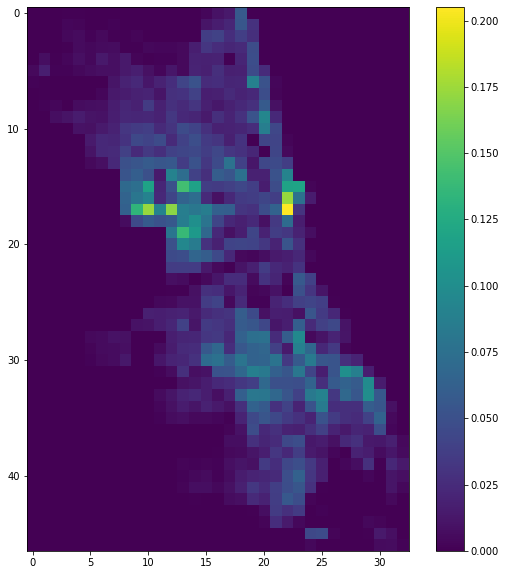

In [10]:
test_set_size = data_group.testing_set.target_shape[0]
crimes = data_group.shaper.unsqueeze(data_group.crimes)
im(crimes.mean(0)[0])
crimes = data_group.crimes
t_range = data_group.t_range

In [11]:
model_results = []

## Historic average model

In [12]:
log.getLogger().setLevel("INFO")

2019-11-01T23:08:46 | root | INFO | =====================================BEGIN=====================================
2019-11-01T23:08:46 | root | INFO | Device: cpu
2019-11-01T23:08:46 | root | INFO | using time step: 8
2019-11-01T23:09:03 | root | INFO | f1_score: 0.32086375587433447 at index 256352, new threshold 0.054739466060334856
2019-11-01T23:09:05 | root | INFO | 
        MODEL METRICS
            Model Name: historic-average
                ROC AUC:            0.774823608825903
                Recall:             0.4505241626182562
                Precision:          0.2288715079652258
                Average Precision:  0.24636050236966572
                Accuracy:           0.8319866419294991
                MCC:                0.23573266614942093          
        
2019-11-01T23:09:05 | root | INFO | 
        MODEL RESULT
            Model Name: historic-average
                ROC AUC:            0.774823608825903
                Recall:             0.4505241626182562
     

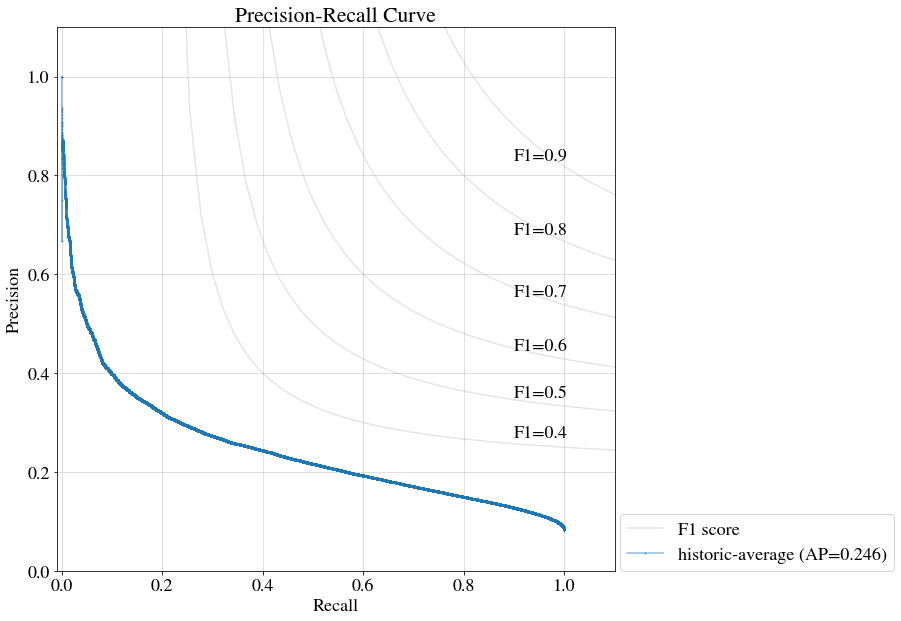

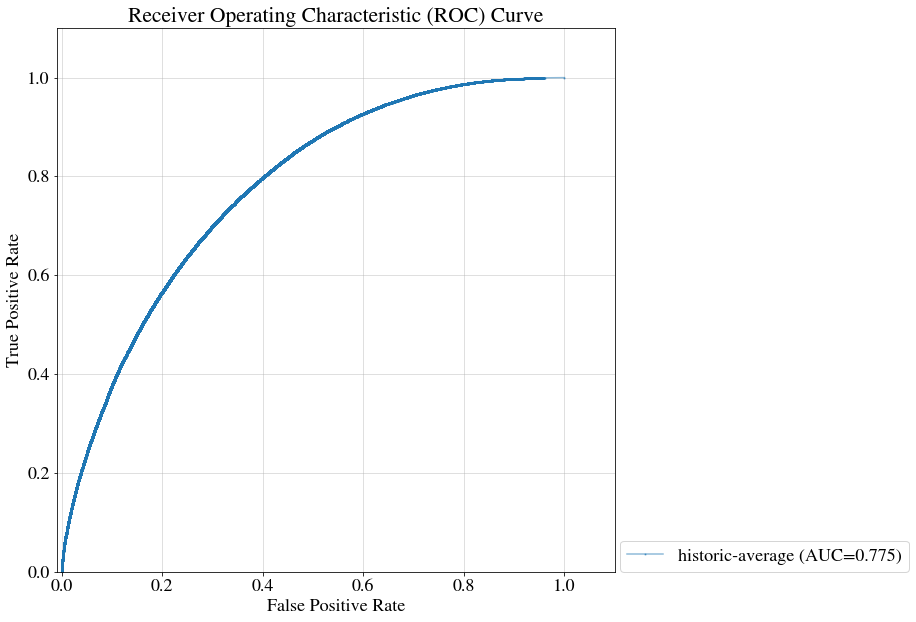

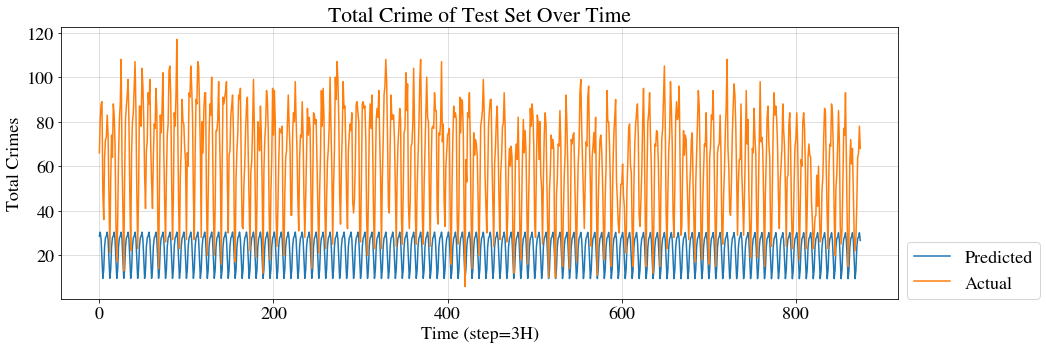

In [13]:
# Create model folder and setup logging for model
model_name = "Historic Average"  # needs to be created
conf.model_name = model_name
model_path = data_path + f"models/{model_name}/"
conf.model_path = model_path
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")



# time step in this context is used for 
freqstr = t_range.freqstr
if freqstr == "H":
    freqstr = "1H"
time_step = int(24 / int(freqstr[:freqstr.find("H")]))
if time_step == 1:
    time_step = 7  # historic average to a week when time scale is daily

log.info(f"using time step: {time_step}")

test_set_size = data_group.testing_set.target_shape[0]

ha = HistoricAverage(step=time_step)
all_crimes = data_group.crimes[:,0]
all_targets = data_group.targets
all_crimes_ha = ha(all_crimes)
all_t_range = data_group.t_range

tst_crimes_ha = all_crimes_ha[-test_set_size:]
tst_targets = all_targets[-test_set_size:]
tst_t_range = all_t_range[-test_set_size:]

trn_probas_pred = all_crimes_ha[time_step+1:-test_set_size] # skip all the nan values
trn_y_true = all_targets[time_step+1:-test_set_size]

thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

tst_y_true = tst_targets
tst_probas_pred = tst_crimes_ha
tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)  


log.info("=====================================END=====================================")

## Mean of training data as future prediction

2019-11-01T23:09:14 | root | INFO | =====================================BEGIN=====================================
2019-11-01T23:09:14 | root | INFO | Device: cpu
2019-11-01T23:09:15 | root | INFO | f1_score: 0.30090412094082986 at index 568, new threshold 0.04827181174859595
2019-11-01T23:09:17 | root | INFO | 
        MODEL METRICS
            Model Name: mean-model
                ROC AUC:            0.7548274166935257
                Recall:             0.4849873981809548
                Precision:          0.19454212454212455
                Average Precision:  0.2110477182079281
                Accuracy:           0.7949625231910946
                MCC:                0.20895730172305532          
        
2019-11-01T23:09:17 | root | INFO | 
        MODEL RESULT
            Model Name: mean-model
                ROC AUC:            0.7548274166935257
                Recall:             0.4849873981809548
                Precision:          0.19454212454212455
                Av

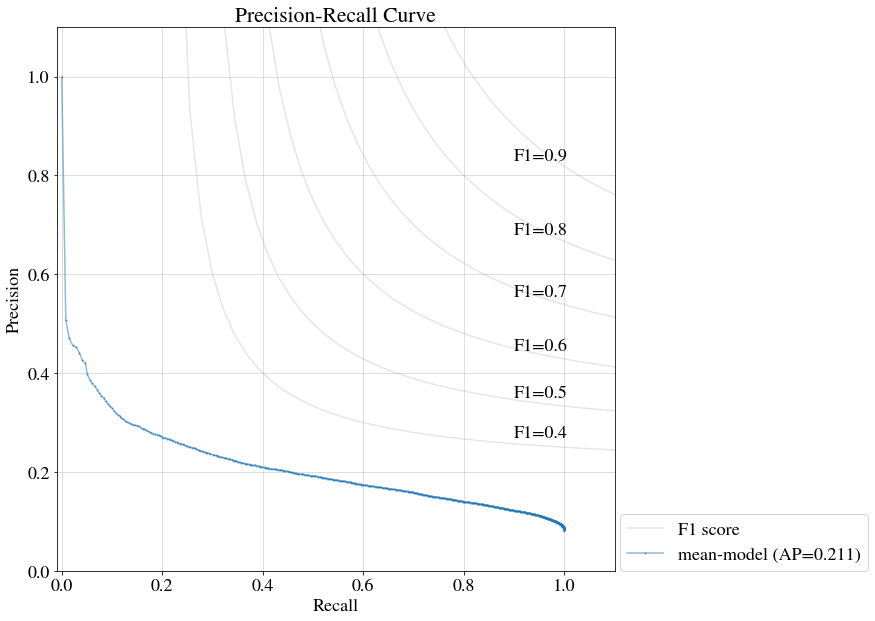

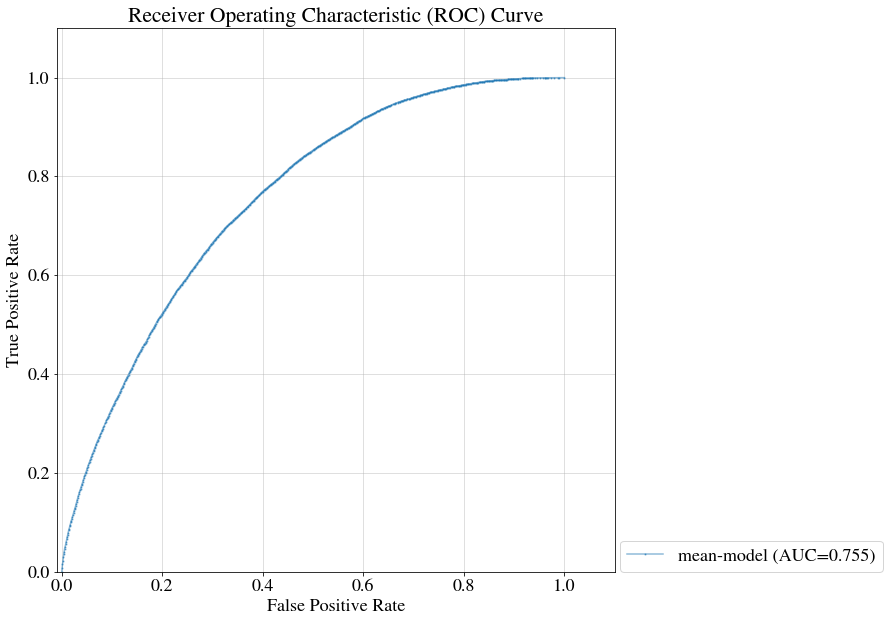

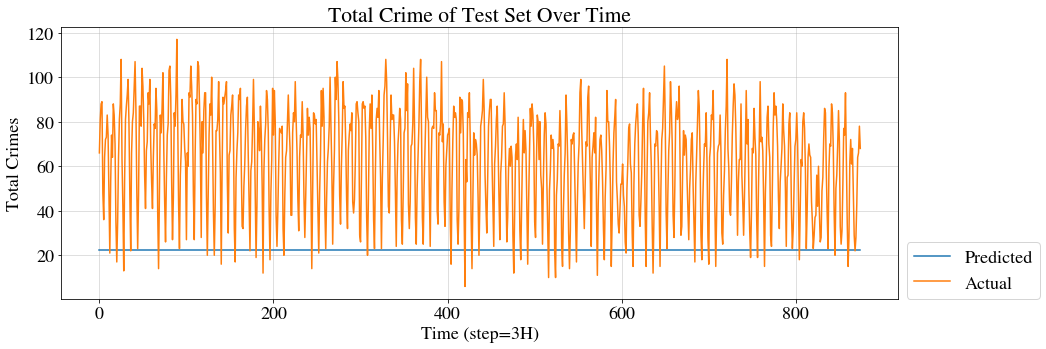

In [14]:
# Create model folder and setup logging for model
model_name = "Train Average"  # needs to be created
conf.model_name = model_name
model_path = data_path + f"models/{model_name}/"
conf.model_path = model_path
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")


test_set_size = data_group.testing_set.target_shape[0]

all_crimes = data_group.crimes[:,0]
all_targets = data_group.targets

trn_crimes = all_crimes[:-test_set_size]
trn_targets = all_targets[:-test_set_size]

tst_crimes = all_crimes[-test_set_size:]
tst_targets = all_targets[-test_set_size:]
tst_t_range = all_t_range[-test_set_size:]

trn_mean = np.mean(trn_crimes,axis=0,keepdims=True)  # keep dims used to make scalar product easy
trn_ones = np.ones_like(trn_crimes,dtype=np.float)
trn_probas_pred = trn_mean*trn_ones

thresh = best_threshold(y_true=trn_targets,
                        probas_pred=trn_probas_pred) # should only come from the train predictions

# only use the training sets - mean
tst_ones = np.ones_like(tst_crimes,dtype=np.float)
tst_probas_pred = trn_mean*tst_ones

tst_y_true = tst_targets
tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)
    
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)  

log.info("=====================================END=====================================")

## Rolling mean of all data 

2019-11-01T23:09:25 | root | INFO | =====================================BEGIN=====================================
2019-11-01T23:09:25 | root | INFO | Device: cpu
2019-11-01T23:09:25 | root | INFO | using time step: 8
2019-11-01T23:09:26 | root | INFO | f1_score: 0.18450185579413678 at index 1, new threshold 0.3010299956639812
2019-11-01T23:09:28 | root | INFO | 
        MODEL METRICS
            Model Name: Rolling Average
                ROC AUC:            0.5491959494110937
                Recall:             0.170909887862074
                Precision:          0.17085995983202484
                Average Precision:  0.09990056031060694
                Accuracy:           0.8652200371057513
                MCC:                0.09753293569953783          
        
2019-11-01T23:09:28 | root | INFO | 
        MODEL RESULT
            Model Name: Rolling Average
                ROC AUC:            0.5491959494110937
                Recall:             0.170909887862074
             

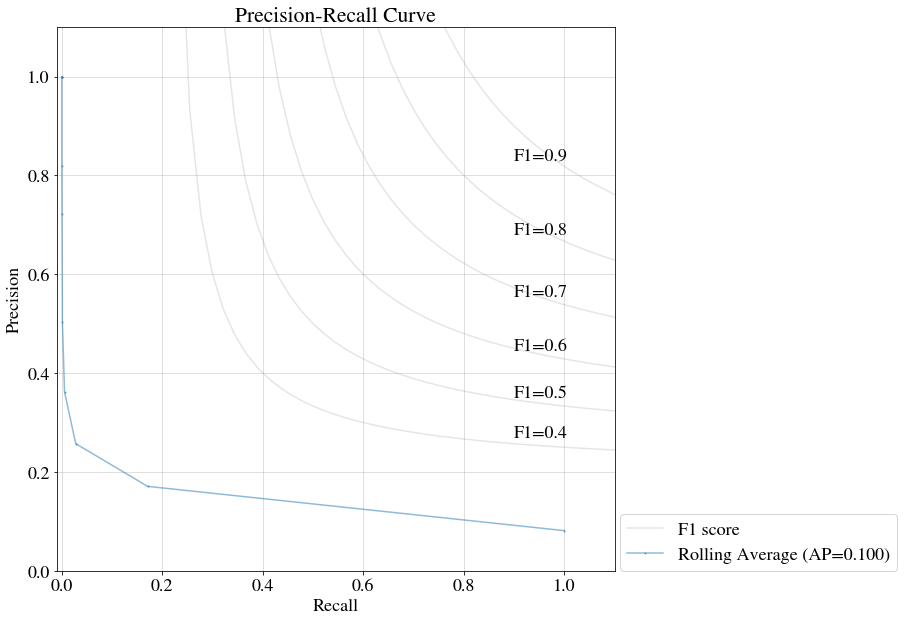

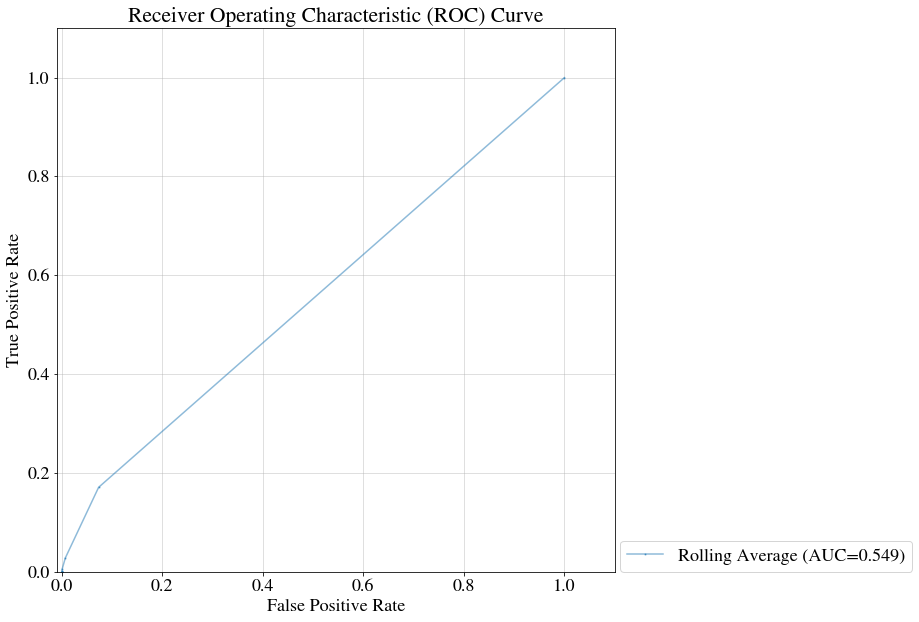

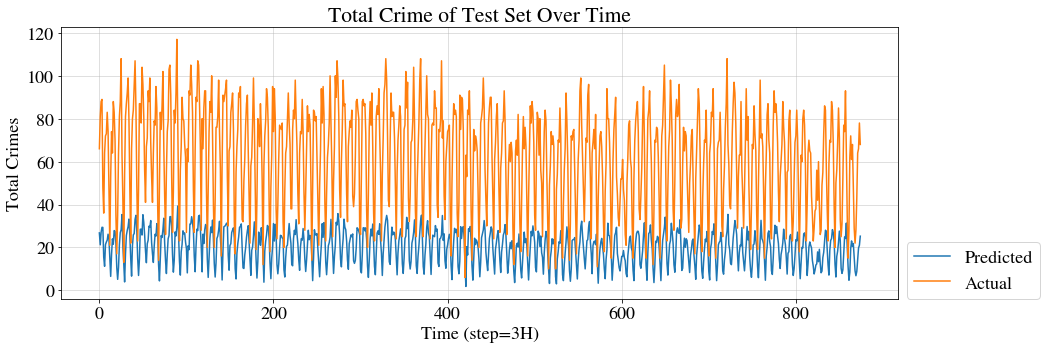

In [15]:
# Create model folder and setup logging for model
model_name = "Rolling Average"  # needs to be created
conf.model_name = model_name
model_path = data_path + f"models/{model_name}/"
conf.model_path = model_path
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")



# time step in this context is used for 
freqstr = t_range.freqstr
if freqstr == "H":
    freqstr = "1H"
time_step = int(24 / int(freqstr[:freqstr.find("H")]))
if time_step == 1:
    time_step = 7  # historic average to a week when time scale is daily

log.info(f"using time step: {time_step}")

test_set_size = data_group.testing_set.target_shape[0]

alpha=1e-2
window_len=1#time_step

ma = ExponentialMovingAverage(alpha=alpha,window_len=window_len)

all_crimes = data_group.crimes[:,0]
all_targets = data_group.targets
all_probas_pred = ma(all_crimes)
all_t_range = data_group.t_range

tst_probas_pred = all_probas_pred[-test_set_size:]
tst_targets = all_targets[-test_set_size:]
tst_t_range = all_t_range[-test_set_size:]

trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
trn_y_true = all_targets[time_step+1:-test_set_size]

thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

tst_y_true = tst_targets
tst_probas_pred = tst_probas_pred
tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)


# tst_y_pred = tst_y_true[:-1]
# tst_y_true = tst_y_true[1:]
# tst_probas_pred = tst_y_pred#tst_y_true + np.random.randn(*np.shape(tst_y_true))/10
    
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)  

log.info("=====================================END=====================================")

## Adding random noise to the predictions

In [ ]:
for noise_std in [0.4,0.8]:
    tst_crimes = data_group.testing_set.targets  # only mask the targets as the outputs


    noise = noise_std*np.random.randn(*np.shape(tst_crimes))
    # should be a flip seeing that the class distribution is so skew

    y_pred_sparse = tst_crimes + noise
    targets_dense = data_group.testing_set.targets
    y_pred_dense = y_pred_sparse

    probas_pred = y_pred_dense.flatten()
    
    N,L = targets_dense.shape
    targets_shape = N,L
    
    y_true = targets_dense.flatten()
    thresh = best_threshold(y_true, probas_pred) # should only come from the train predictions
    y_pred = np.copy(probas_pred)
    y_pred[y_pred >= thresh] = 1
    y_pred[y_pred < thresh] = 0

    noise_model_result = ModelResult(model_name=f"Noise model std={noise_std}",
                                    y_true=y_true,
                                    y_pred=y_pred,
                                    probas_pred=probas_pred,
                                    t_range=data_group.testing_set.t_range,
                                     shaper=data_group.shaper)

    model_results.append(noise_model_result)

In [ ]:
for result in model_results:
    print(result)

pr_plotter = PRCurvePlotter()
for result in model_results:
    pr_plotter.add_curve(result.y_true, result.probas_pred, label_name=result.model_name)
pr_plotter.show()
# pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
for result in model_results:
    roc_plotter.add_curve(result.y_true, result.probas_pred, label_name=result.model_name)
roc_plotter.show()
# roc_plotter.savefig(model_path + "plot_roc_curve.png")

In [ ]:
# todo create function do unflatten y_true, y_probs, and probas_true
# use shape of the model and just rnp.reshape



## [Hawkes Model](https://x-datainitiative.github.io/tick/modules/generated/tick.hawkes.HawkesSumExpKern.html)
does support multi variate but we are only using univariate for now
### Data Analysis Hawks-proces using the EM kernel

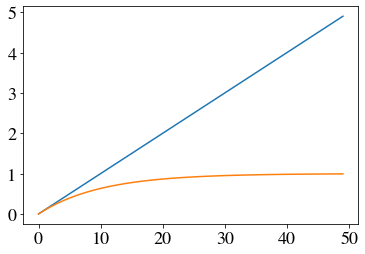

In [18]:
f = lambda x: 1 - np.exp(-1*x)
a = np.arange(0,5,.1)
plt.plot(a)
plt.plot(f(a))

In [ ]:
trn_inpt = data_group.training_set.crimes[:,0]
trn_trg = data_group.training_set.targets

tst_inpt = data_group.testing_set.crimes[:,0]
tst_trg = data_group.testing_set.targets


N,L = np.shape(trn_inpt)

model = IndHawkesModel(kernel_size=time_step*3 + 1)
trn_out = model.fit_transform(trn_inpt)
tst_out = model.transform(tst_inpt)

limit = 200
top_k = 10
i = 3000


# todo check how this influences the ROC and PR curves
def i2p(intensity):
    """
    intensity to probability
    """
    return 1 - np.exp(-1*intensity)
    
       
for i in range(top_k):
    for j in range(2):
        print(f"-------------------------------{j}----------------------------------")
        plt.figure(figsize=(10,2))
        plt.plot(tst_trg[i:i+limit,i])

        y_true = tst_trg[:,i]
        if j == 0:
            probas_pred = i2p(tst_out[:,i])
        else:     
            probas_pred = tst_out[:,i]

        thresh = best_threshold(y_true, probas_pred) # should only come from the train predictions
        y_pred = np.copy(probas_pred)
        y_pred[y_pred >= thresh] = 1
        y_pred[y_pred < thresh] = 0

        print(classification_report(y_true=y_true,y_pred=y_pred))

        plt.plot(y_pred[i:i+limit])
        plt.plot(probas_pred[i:i+limit])
    #     plt.ylim([0,1])
        plt.show()

        print(f"------------------------------------------------------------------")

        

In [ ]:
plt.plot(np.linspace(0,4,100))
plt.plot(i2p(np.linspace(0,4,100)))

In [ ]:
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report

In [ ]:
for realization in realizations[:5]:#multi.timestamps:
    plt.figure(figsize=(10,1))
    for var in realization:
        plt.scatter(var, np.ones_like(var), alpha=.2, marker="|")    
    plt.show()

## sklearn dummy classifier

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier(strategy='prior')
dummy.fit(X,y)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X,y)

print("log_reg:",accuracy_score(y, lr.predict_proba(X)[:,1].round()))

for strat in ['stratified', 'most_frequent', 'prior', 'uniform']:
    dummy = DummyClassifier(strategy=strat)
    dummy.fit(X,y)
    print(f"dummy ({strat}):",accuracy_score(y, dummy.predict_proba(X)[:,1].round())) 

## logistic regression model

In [ ]:
print(X.shape, y.shape)
get mean model as the starting position.
then train with only the new values to see the difference
print(data_group.crimes[:,0].shape)

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
X, y = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')

clf..fit(X, y)
clf.predict(X[:2, :])
clf.predict_proba(X[:2, :]) 
clf.score(X, y)

print(f"clf.coef_ -> {clf.coef_}")

plt.figure(figsize=(15,15))
X = data_group.crimes[:400,0,data_group.sorted_indices]
aspect = X.shape[1]/X.shape[0]

plt.imshow(X=X,aspect=aspect,cmap='viridis')
plt.show()
    